# Рекомендация тарифов

## Описание проекта

Есть данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — она уже сделана в прошлом проекте.

Необходимо построить модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверить *accuracy* на тестовой выборке самостоятельно.

В процессе исследования:

- Разделить исходные данные на обучающую, валидационную и тестовую выборки.
- Исследовать качество разных моделей, меняя гиперпараметры. 
- Проверить качество модели на тестовой выборке.
- Проверить модели на вменяемость. 
- Сделать выводы.

### Описание данных

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:

- `сalls` — количество звонков,
- `minutes` — суммарная длительность звонков в минутах,
- `messages` — количество sms-сообщений,
- `mb_used` — израсходованный интернет-трафик в Мб,
- `is_ultra` — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

## Откройте и изучите файл

### Импортируем необходимые библиотеки для работы

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import tree

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

### Загружаем данные из файла `users_behavior.csv` в датафрейм `tariff`.

In [2]:
try:
    tariff = pd.read_csv("/datasets/users_behavior.csv")
except FileNotFoundError:
    tariff = pd.read_csv("https://code.s3.yandex.net/datasets/users_behavior.csv")

### Посмотрим правильность загрузки данных методом `head()` и информацию по дарафрейму методом `info()`

In [3]:
tariff.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [4]:
tariff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


Всего **3214** пользователей. Для каждого известно количество звонков, минут, сообщений и мегабайт-интернет трафика, а также каким тарифом пользуется клиент (если `0`, то **Смарт**, если `1`,  то **Ультра**). Данные обработаны в прошлом проекте - пропусков нету.

In [5]:
tariff['is_ultra'].value_counts()

0    2229
1     985
Name: is_ultra, dtype: int64

## Разбейте данные на выборки

### Для дальнейшего исследования сформируем датасеты для признаков и целевого признака.

Целевой признак `target` - столбец `is_ultra`. В столбце указано какой тариф использует клиент, Смарт или Ультра. Признак является категориальным.

Остальные столбцы будут являтся признаками - `features`.

In [6]:
features = tariff.drop(['is_ultra'], axis=1)
target = tariff['is_ultra']

### Разобъём данные на 3 выборки.

- обучающую, 
- валидационную,
- тестовую.

Размеры тестового и валидационного наборов обычно равны. Исходные данные разбиваем в соотношении 3:1:1 (60% : 20% : 20%)

Используем параметр `stratify` для распределение таргетов во всех новых датасетах.
    

In [7]:
features_train, features_test, target_train, target_test = train_test_split(
    features,
    target,
    train_size=0.6,
    test_size=0.4,
    random_state=1234,
    stratify=target)
features_test, features_valid, target_test, target_valid = train_test_split(
    features_test,
    target_test,
    test_size=0.5,
    random_state=1234,
    stratify=target_test)

### Проверяем разбиение на выборки:

In [8]:
print(features_train.shape)
print(target_train.shape)
print(features_valid.shape)
print(target_valid.shape)
print(features_test.shape)
print(target_test.shape)

(1928, 4)
(1928,)
(643, 4)
(643,)
(643, 4)
(643,)


Исходный датасет разделили верно.

## Исследуйте модели

### В исследованиия будем проверять следующие модели машинного обучения:

- Решающее дерево,
- Случайный лес,
- Логистическая регрессия.

#### Решающее дерево.

Переберем варианты максимальной глубины дерева от 1 до 16.

In [9]:
accuracy_list = []
max_depth_list = []
accuracy_list_train = []
max_depth_list_train = []

best_model = None
best_accuracy = 0
best_depth = 0

for depth in range(1, 16):
    model_tree = DecisionTreeClassifier(
        random_state=1234, max_depth=depth)  # присваиваем модели имя
    model_tree.fit(features_train, target_train)  # обучаем
    prediction_tree = model_tree.predict(features_valid)  # проверяем
    result_accuracy = round(accuracy_score(prediction_tree, target_valid), 6)
    prediction_tree_train = model_tree.predict(features_train)  # проверяем
    result_accuracy_train = round(
        accuracy_score(prediction_tree_train, target_train), 6)
    accuracy_list.append(result_accuracy)
    max_depth_list.append(depth)
    accuracy_list_train.append(result_accuracy_train)
    max_depth_list_train.append(depth)
    if best_accuracy < result_accuracy:
        best_model = model_tree
        best_accuracy = result_accuracy
        best_depth = depth

print(
    f'''Наилучшая точность в {best_accuracy} в модели решающего леса достигается при глубине {best_model.max_depth}'''
)

data_result = pd.DataFrame({
    'Максимальная глубина дерева': max_depth_list,
    'Значение accuracy': accuracy_list
})
data_result_train = pd.DataFrame({
    'Максимальная глубина дерева': max_depth_list_train,
    'Значение accuracy': accuracy_list_train
})

Наилучшая точность в 0.805599 в модели решающего леса достигается при глубине 9


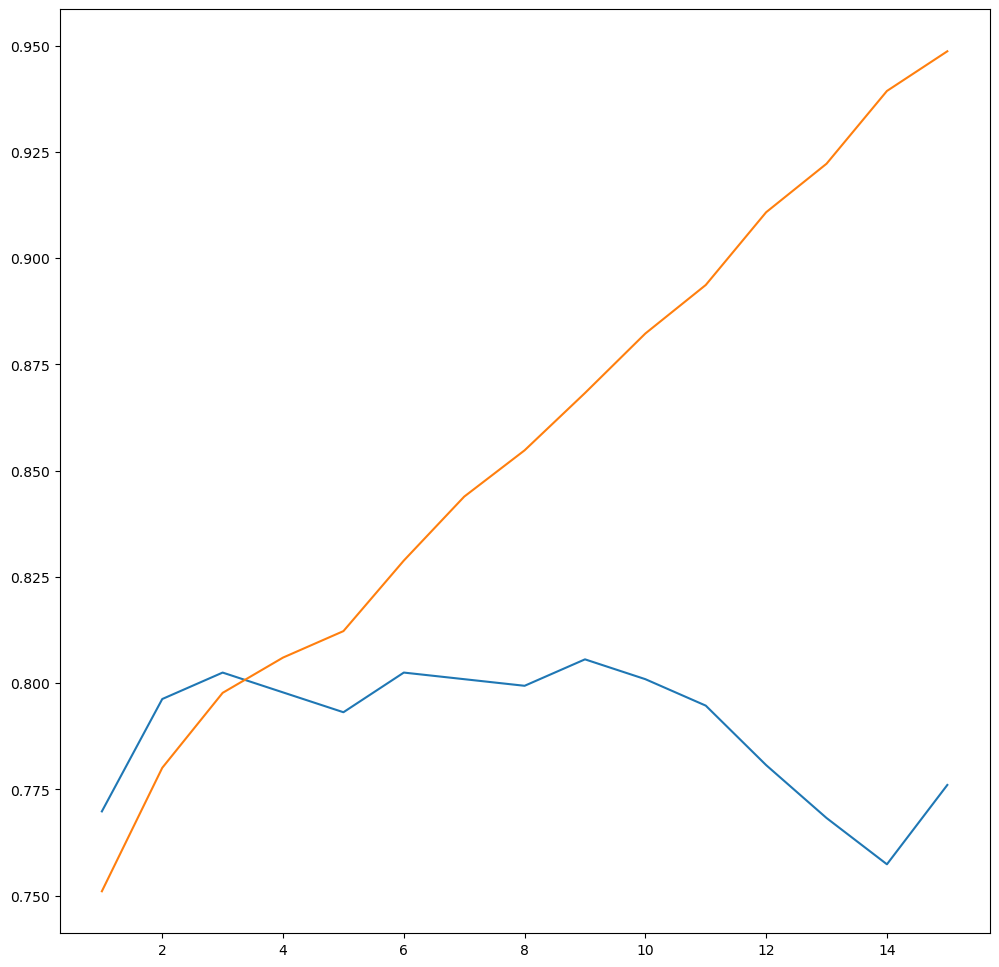

In [10]:
plt.figure(figsize=(12, 12))
plt.plot(data_result['Максимальная глубина дерева'],
         data_result['Значение accuracy'])
plt.plot(data_result_train['Максимальная глубина дерева'],
         data_result_train['Значение accuracy'])
plt.show()

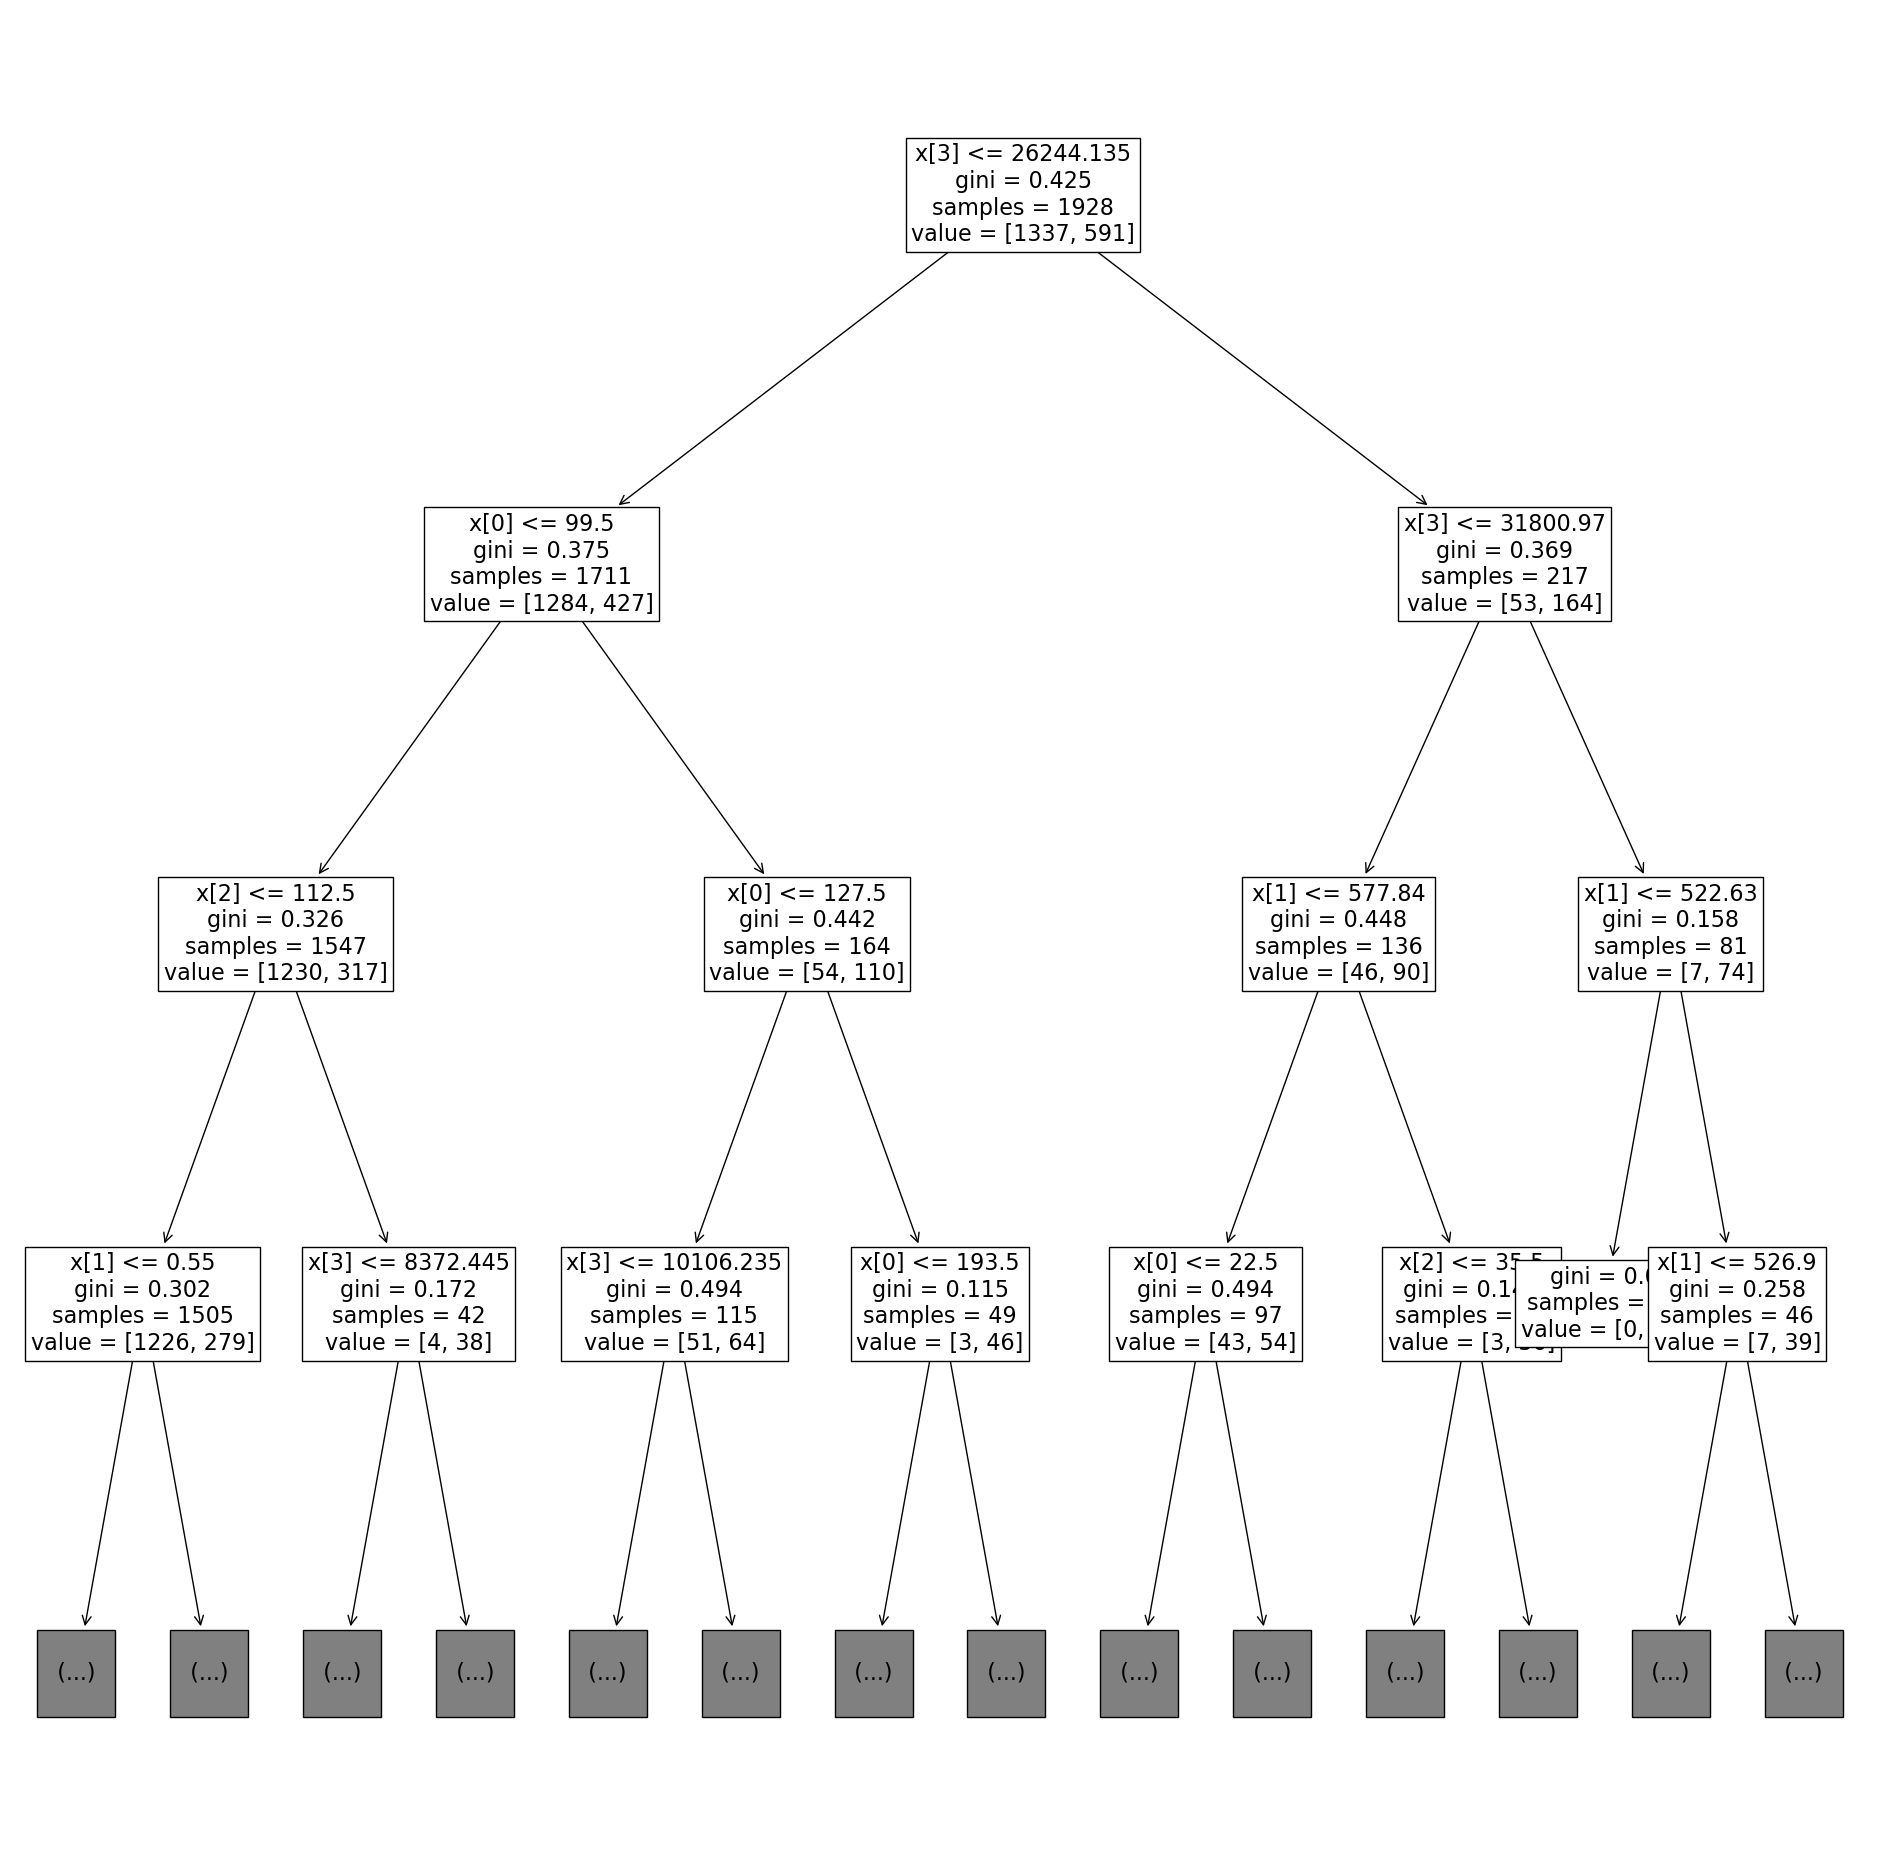

In [11]:
plt.figure(figsize=(24, 24))
tree.plot_tree(model_tree.fit(features_train, target_train),
               max_depth=3,
               fontsize=16)
plt.show()

При максимальной глубине дерева = 9, качество модели "Решающее дерево" - 0.805599.

#### Случайный лес.

In [12]:
best_model = None
best_accuracy = 0
best_estim = 0
for depth in range(1, 11):
    for n_estim in range(1, 51):
        model_forest = RandomForestClassifier(random_state=1234,
                                              max_depth=depth,
                                              n_estimators=n_estim)
        model_forest.fit(features_train, target_train)
        predictions_forest = model_forest.predict(features_valid)
        accuracy_forest = round(
            accuracy_score(target_valid, predictions_forest), 6)
        if best_accuracy < accuracy_forest:
            best_model = model_forest
            best_accuracy = accuracy_forest
            best_depth = depth
            est_estim = n_estim

print(
    f'''Наилучшая точность в {best_accuracy} в модели случайного леса достигается при глубине {best_model.max_depth} и количестве деревьев {best_model.n_estimators}'''
)

Наилучшая точность в 0.825816 в модели случайного леса достигается при глубине 7 и количестве деревьев 14


Самый лучший результат получили при глубине дерева 7 и количестве деревьев 14. Доля правильных ответов составляет 82,5816 %.

#### Логистическая регрессия.

In [13]:
model_regression = LogisticRegression()
model_regression.fit(features_train, target_train)
predictions_model_regression = model_regression.predict(features_valid)
accuracy_model_regression = round(accuracy_score(target_valid, predictions_model_regression), 6)

print('Максимальное значение accuracy:', accuracy_model_regression)

Максимальное значение accuracy: 0.754277


Логистическая регрессия показала самый худший вариант - 75,427 %

**Вывод**

- Лучшая модель - Случайные лес
- Худшая модель - Логистическая регрессия

## Проверьте модель на тестовой выборке

### Проверим модели на тестовой выборке.

Для этого возьмем гиперпараметры лучших моделей на валидационной выборке:

- Случайный лес - `max_depth=7` , `n_estimators=14`

#### Случайный лес.

In [14]:
model_forest_test = RandomForestClassifier(max_depth=7 , n_estimators=14, random_state=1234)
model_forest_test.fit(features_train,target_train)
prediction_forest_test = model_forest_test.predict(features_test)

print('Максимальное значение accuracy:', round(accuracy_score(prediction_forest_test, target_test), 6))

Максимальное значение accuracy: 0.802488


Значение на тесотовой выборке хуже чем на валидационной 0.802488 против 0.825816

**Вывод**

Тестовая выборка сработала чуть хуже, но совсем не на много

Попробуем переобучить модель тренировочной + валидационной выборке.
Объединим тренировочную и валидачионную выборки и проверим на тестовой.

In [15]:
new_features_train = pd.concat((features_valid, features_train), axis=0, join='outer')
new_target_train = pd.concat((target_valid, target_train), axis=0, join='outer')

In [16]:
model_forest_new = RandomForestClassifier(random_state=1234, max_depth=7, n_estimators=14)
model_forest_new.fit(new_features_train, new_target_train)
predictions_forest_new = model_forest_new.predict(features_valid)
accuracy_forest_new = round(accuracy_score(target_valid, predictions_forest_new), 6)
                      
print(f'''Точность в {accuracy_forest_new} в модели случайного леса при глубине 7 и количестве деревьев 14''')

Точность в 0.856921 в модели случайного леса при глубине 7 и количестве деревьев 14


In [17]:
model_forest_test_new = RandomForestClassifier(max_depth=7 , n_estimators=14,random_state=1234)
model_forest_test_new.fit(new_features_train, new_target_train)
prediction_forest_test_new = model_forest_test_new.predict(features_test)

print('Значение accuracy:', round(accuracy_score(target_test, prediction_forest_test_new), 6))

Значение accuracy: 0.788491


Переобученная модель дала еще большую точность, но на тестовой показала результат еще хуже чем был...

## (бонус) Проверьте модели на адекватность

Проверим модель на адекватность путем использования модели DummyClassifier из библиотеки sklearn.

Данная модель предсказывает значения, не учитывая передаваемых ей признаков. 

In [18]:
model_dummy = DummyClassifier(strategy="most_frequent") # most_frequent, возвращает наиболее часто встречающееся значения.
model_dummy.fit(features_train, target_train)
predictions_dummy = model_dummy.predict(features_test)
results = accuracy_score(target_test, predictions_dummy)

print(results)

0.6936236391912908


**Вывод**

Значения качества ниже чем у выбранной модели. Можно сделать вывод об адекватности модели.

## Общий вывод.

Были обучены три модели "Решающее дерево", "Случайный лес" и "Логистическая регрессия". В первых двух моделях изменяя гиперпараметры были найдены максимальные значения качества.

- Решающее дерево - accuracy = 0.805599, max_depth = 9 на валидационной выборке,
- Случайный лес - accuracy = 0.825816, max_depth = 7 , n_estimators = 14 на валидационной выборке,
- Логистическая регрессия - accuracy = 0.754277 на валидационной выборке.

На тестовой выборке результат получился чуть хуже.

Лучший результат показала модель Случайного леса. Значение качества 0.802488, что превышает требуемое значение доли правильных ответов в 0.75.

После проверки на адекватность можно убедиться, что исследумая модель лучше предсказывает в сравнении со случайными предсказаниями.

## Чек-лист готовности проекта

- [x] Jupyter Notebook открыт
- [x] Весь код исполняется без ошибок
- [x] Ячейки с кодом расположены в порядке исполнения
- [x] Выполнено задание 1: данные загружены и изучены
- [x] Выполнено задание 2: данные разбиты на три выборки
- [x] Выполнено задание 3: проведено исследование моделей
    - [x] Рассмотрено больше одной модели
    - [x] Рассмотрено хотя бы 3 значения гипепараметров для какой-нибудь модели
    - [x] Написаны выводы по результатам исследования
- [x] Выполнено задание 3: Проведено тестирование
- [x] Удалось достичь accuracy не меньше 0.75